In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import moscot as mt
import scotty as sct

from scipy.spatial import distance_matrix
from sklearn.kernel_approximation import Nystroem
from sklearn.metrics import adjusted_mutual_info_score

In [2]:
%load_ext autoreload
%autoreload 2

# Overview

This notebook will highlight some of the trajectory analysis tools included in `scotty-tools`, including 
:

* "Fate flow" visualization
* Trajectory integration and clustering
* Fate entropy analysis

# Dataset

In [3]:
adata = mt.datasets.hspc()
adata

AnnData object with n_obs × n_vars = 4000 × 2000
    obs: 'day', 'donor', 'cell_type', 'technology', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'hvg', 'neighbors', 'neighbors_atac', 'pca', 'umap'
    obsm: 'X_lsi', 'X_pca', 'X_umap_ATAC', 'X_umap_GEX', 'peaks_tfidf'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'neighbors_atac_connectivities', 'neighbors_atac_distances'

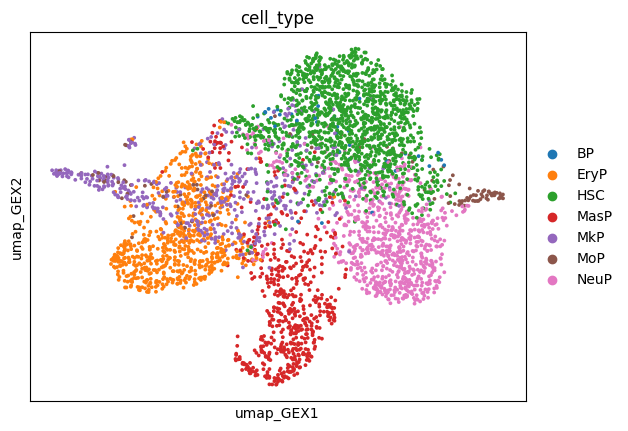

In [4]:
sc.pl.embedding(adata, basis='umap_GEX', color='cell_type')

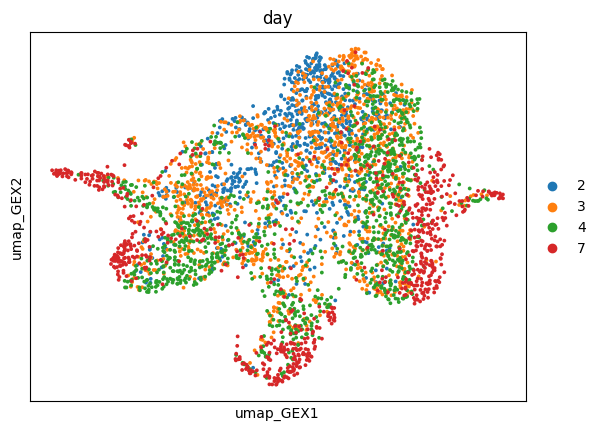

In [5]:
sc.pl.embedding(adata, basis='umap_GEX', color='day')

## Fit trajectories using `moscot`

First, we will fit optimal transport trajectories using the computational machinery built into `moscot`. In addition, we will check for outliers in predicted growth rates, and clip them to prevent trajectory collapse.

We compute the prior growth rates from proliferation and apoptosis gene set scores and apply a scaling factor, $\sigma$, that determines how heavily the raw gene set scores impact the prior growth rates, via the formula:

$$g = \exp\left[\frac{\left(y_\text{prolif.} - y_\text{apop.}\right)\left(t_\text{target} - t_\text{source}\right)}{\sigma}\right]$$

In [22]:
ot_model = sct.models.trajectory.MoscotModel.from_adata(adata)
ot_model.score_genes_for_marginals(gene_set_proliferation='human', gene_set_apoptosis='human')
ot_model.prepare(time_key='day', marginal_kwargs={'scaling': 2})

       'BUB1', 'CASP8AP2', 'CBX5', 'CCNB2', 'CCNE2', 'CDC20', 'CDC25C',
       'CDC45', 'CDC6', 'CDCA2', 'CDCA3', 'CDCA7', 'CDCA8', 'CDK1', 'CENPA',
       'CENPF', 'CHAF1B', 'CKAP2', 'CKAP2L', 'CKAP5', 'CKS1B', 'CKS2', 'CLSPN',
       'CTCF', 'DLGAP5', 'DSCC1', 'DTL', 'E2F8', 'ECT2', 'EXO1', 'FAM64A',
       'FEN1', 'G2E3', 'GAS2L3', 'GINS2', 'GMNN', 'GTSE1', 'HELLS', 'HJURP',
       'HMGB2', 'HMMR', 'HN1', 'KIF11', 'KIF20B', 'KIF23', 'KIF2C', 'LBR',
       'MCM2', 'MCM4', 'MCM5', 'MCM6', 'MLF1IP', 'MSH2', 'NASP', 'NCAPD2',
       'NDC80', 'NEK2', 'NUF2', 'NUSAP1', 'PCNA', 'POLA1', 'POLD3', 'PRIM1',
       'PSRC1', 'RAD51', 'RAD51AP1', 'RANGAP1', 'RFC2', 'RPA2', 'RRM1', 'RRM2',
       'SLBP', 'SMC4', 'TACC3', 'TIPIN', 'TMPO', 'TOP2A', 'TPX2', 'TTK',
       'TUBB4B', 'TYMS', 'UBR7', 'UHRF1', 'UNG', 'USP1', 'WDR76'],
      dtype='object')
       'BCAP31', 'BCL10',
       ...
       'TIMP2', 'TNF', 'TNFRSF12A', 'TNFSF10', 'TOP2A', 'TSPO', 'TXNIP',
       'VDAC2', 'WEE1', 'XIAP'],
      d

Let's look at the prior growth rates more closely:

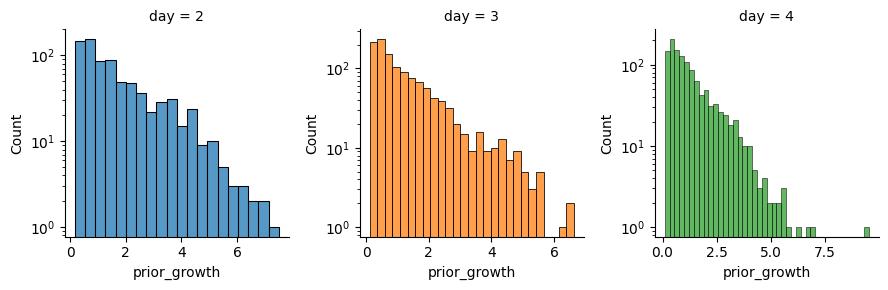

In [24]:
adata.obs['prior_growth'] = ot_model.moscot_model.prior_growth_rates
df_growth = adata.obs[['day', 'prior_growth']]
df_growth = df_growth.loc[~df_growth['prior_growth'].isna()]
df_growth['day'] = df_growth['day'].cat.remove_unused_categories()

g = sns.FacetGrid(df_growth, col='day', hue='day', sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x='prior_growth')
g.set(yscale='log')

There are a few outliers at each source day with high prior growth rates. Due to the exponential population model, these can exert a high amount of influence on the trajectory when there are large time gaps. In the extreme, this may collapse the entirety of the trajectory onto a single cell. To avoid this undesirable behavior, we can clip the growth rates for each timepoint at an upper threshold of our choosing.

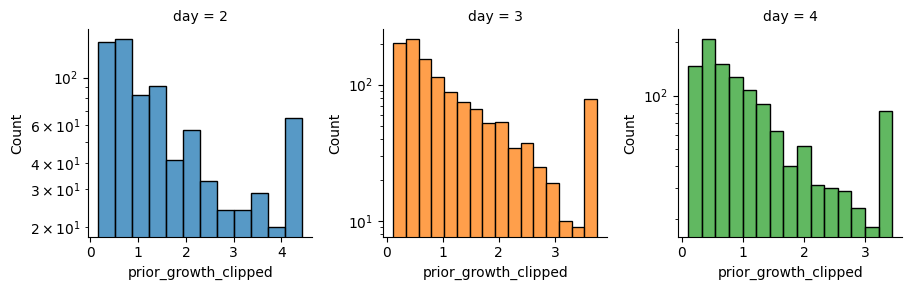

In [26]:
ot_model.clip_growth_rates(upper_quantile=0.95)

adata.obs['prior_growth_clipped'] = ot_model.moscot_model.prior_growth_rates
df_growth = adata.obs[['day', 'prior_growth_clipped']]
df_growth = df_growth.loc[~df_growth['prior_growth_clipped'].isna()]
df_growth['day'] = df_growth['day'].cat.remove_unused_categories()

g = sns.FacetGrid(df_growth, col='day', hue='day', sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x='prior_growth_clipped')
g.set(yscale='log')

Clipping the growth rates effectively creates a larger pool of ancestors at each source timepoint.

Now, we can solve the OT problem.

In [27]:
ot_model.solve(epsilon=0.01, tau_a=0.95, tau_b=0.9995, scale_cost='mean')

INFO     Solving `3` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(766, 1235)].                                   
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1235, 1201)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1201, 798)].                                   


Let's visualize how the (clipped) prior growth rates compare to the posterior growth rates after fitting:

/home/alpaca/miniforge3/envs/scotty-tools-dev/lib/python3.12/site-packages/moscot/problems/time/_mixins.py:452: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df_1, df_2], verify_integrity=True)


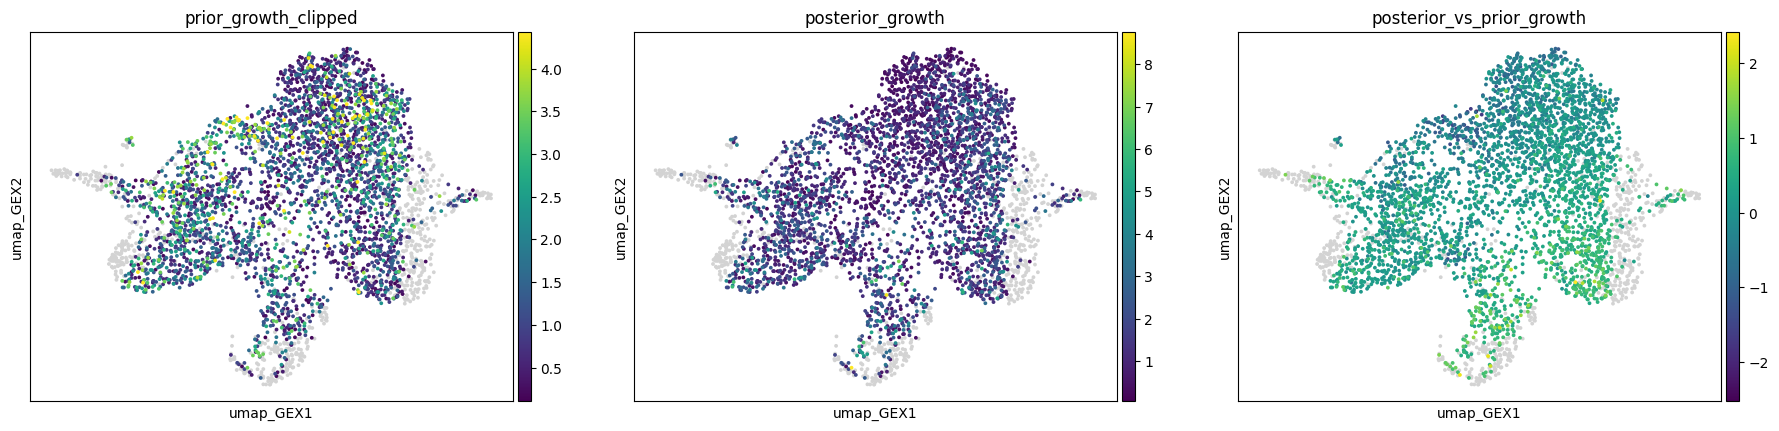

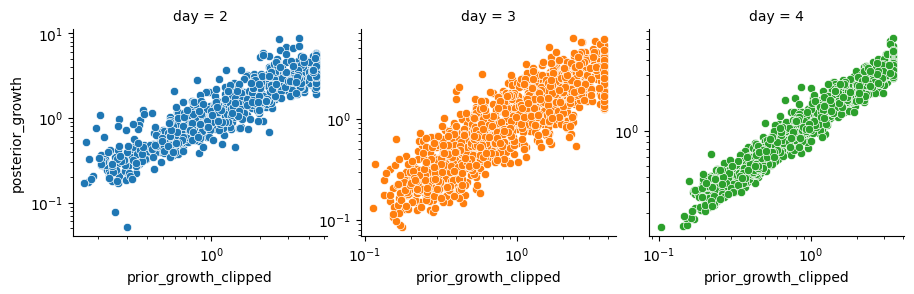

In [29]:
adata.obs['posterior_growth'] = ot_model.moscot_model.posterior_growth_rates
adata.obs['posterior_vs_prior_growth'] = np.log2(adata.obs['posterior_growth'] / adata.obs['prior_growth_clipped'])

sc.pl.embedding(adata, basis='umap_GEX', color=['prior_growth_clipped', 'posterior_growth', 'posterior_vs_prior_growth'])

df_growth = adata.obs[['day', 'prior_growth_clipped', 'posterior_growth']]
df_growth = df_growth.loc[~df_growth['prior_growth_clipped'].isna()]
df_growth['day'] = df_growth['day'].cat.remove_unused_categories()

g = sns.FacetGrid(df_growth, col='day', hue='day', sharey=False, sharex=False)
g.map_dataframe(sns.scatterplot, x='prior_growth_clipped', y='posterior_growth')
g.set(xscale='log', yscale='log')

We see good agreement between the prior and posterior growth rates.

## Plot fate-flow Sankeys using `scotty-tools`

We can visualize the differentiation relationships between cell types over time by using a Sankey diagram to summarize "fate flows":

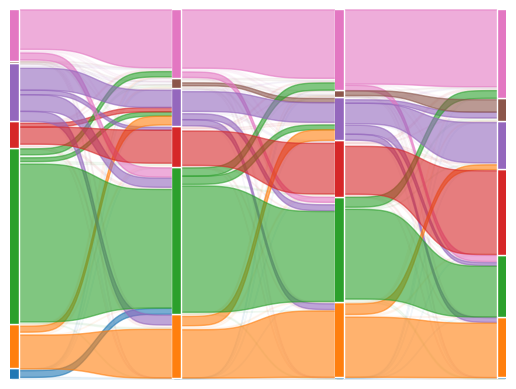

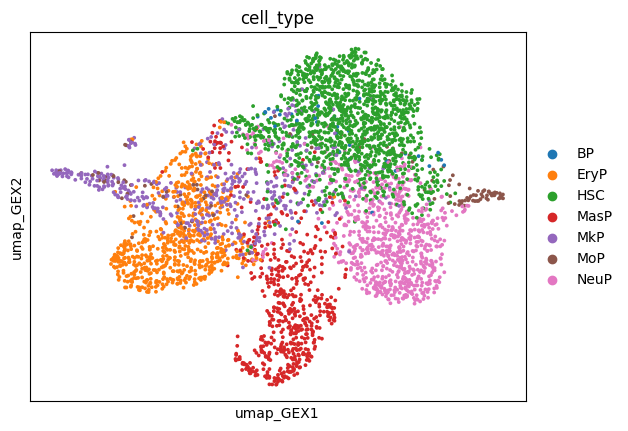

In [8]:
sankey_cell_type = sct.plotting.Sankey(ot_model, adata.obs['cell_type'])
_ = sankey_cell_type.plot_all_transitions(min_flow_threshold=0.01)
sc.pl.embedding(adata, basis='umap_GEX', color='cell_type')

## Cluster trajectories using `scotty-tools`

In [9]:
gammas = dict()
for day, df in adata.obs.groupby('day'):
    X = adata[df.index].obsm['X_pca']
    D = distance_matrix(X, X)
    sig = np.median(D[np.triu_indices_from(D, k=1)])
    gammas[day] = 1 / sig**2

print(gammas)

/tmp/ipykernel_1026520/2671872133.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for day, df in adata.obs.groupby('day'):


{2: np.float64(0.0008330464422353496), 3: np.float64(0.0005341518066065586), 4: np.float64(0.0004700454107315651), 7: np.float64(0.00032286764634276903)}


In [11]:
feats = dict()
for day, df in adata.obs.groupby('day'):
    phi = Nystroem(n_components=50, gamma=gammas[day], random_state=585)
    X = phi.fit_transform(adata[df.index].obsm['X_pca'])
    feats[day] = pd.DataFrame(X, index=df.index)

X_tkme = sct.models.featurize.featurize_trajectories(feats, ot_model)

/tmp/ipykernel_1026520/3997101442.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for day, df in adata.obs.groupby('day'):
2026-02-22 17:33:47,282:kernel_trajectory_featurization:INFO:Estimating trajectory mean embeddings...
100%|██████████| 4/4 [00:00<00:00,  7.25it/s]


In [12]:
adata.obsm['X_tkme'] = X_tkme[adata.obs_names].X
sc.pp.pca(adata, obsm='X_tkme', key_added='X_pca_tkme')
sc.pp.neighbors(adata, use_rep='X_pca_tkme', key_added='neighbors_tkme', n_neighbors=30)
sc.tl.umap(adata, neighbors_key='neighbors_tkme', key_added='X_umap_TKME')

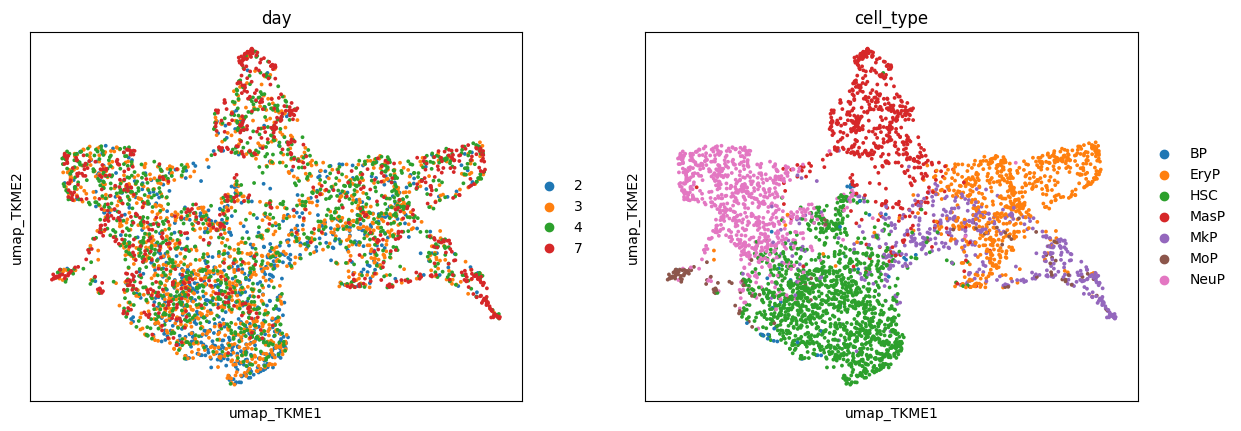

In [13]:
sc.pl.embedding(adata, basis='umap_TKME', color=['day', 'cell_type'])

/tmp/ipykernel_1026520/4195242070.py:1: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(adata, resolution=1, neighbors_key='neighbors', key_added='leiden_GEX')
/tmp/ipykernel_1026520/4195242070.py:2: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(adata, r

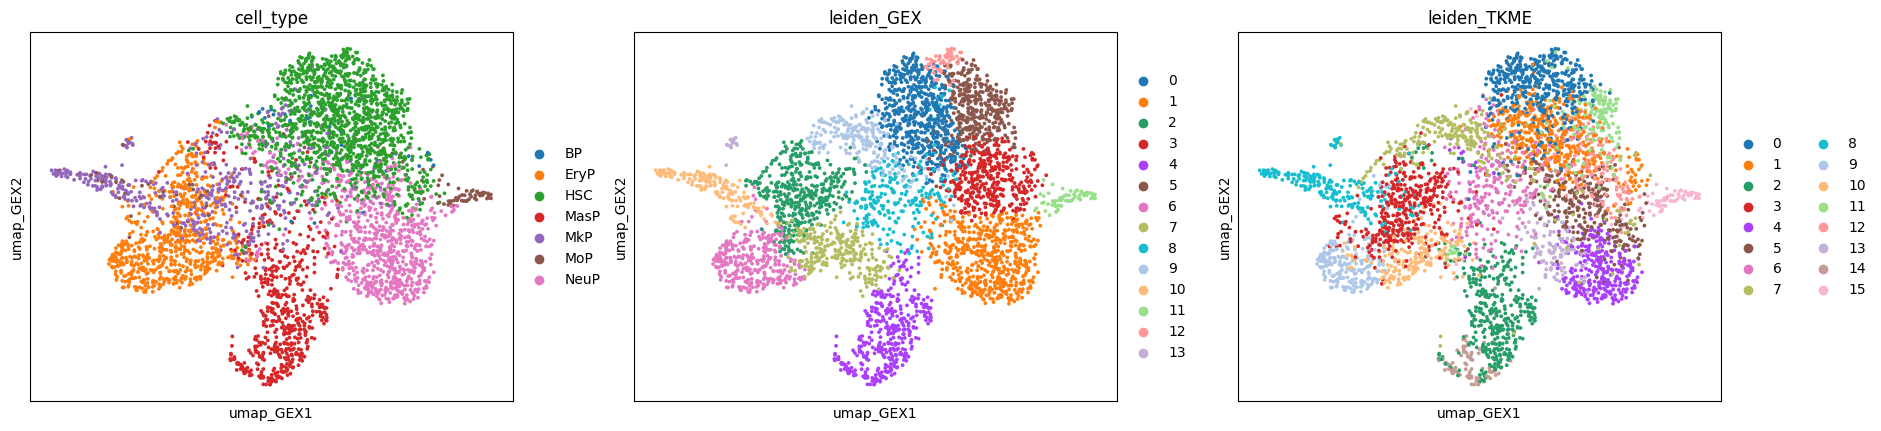

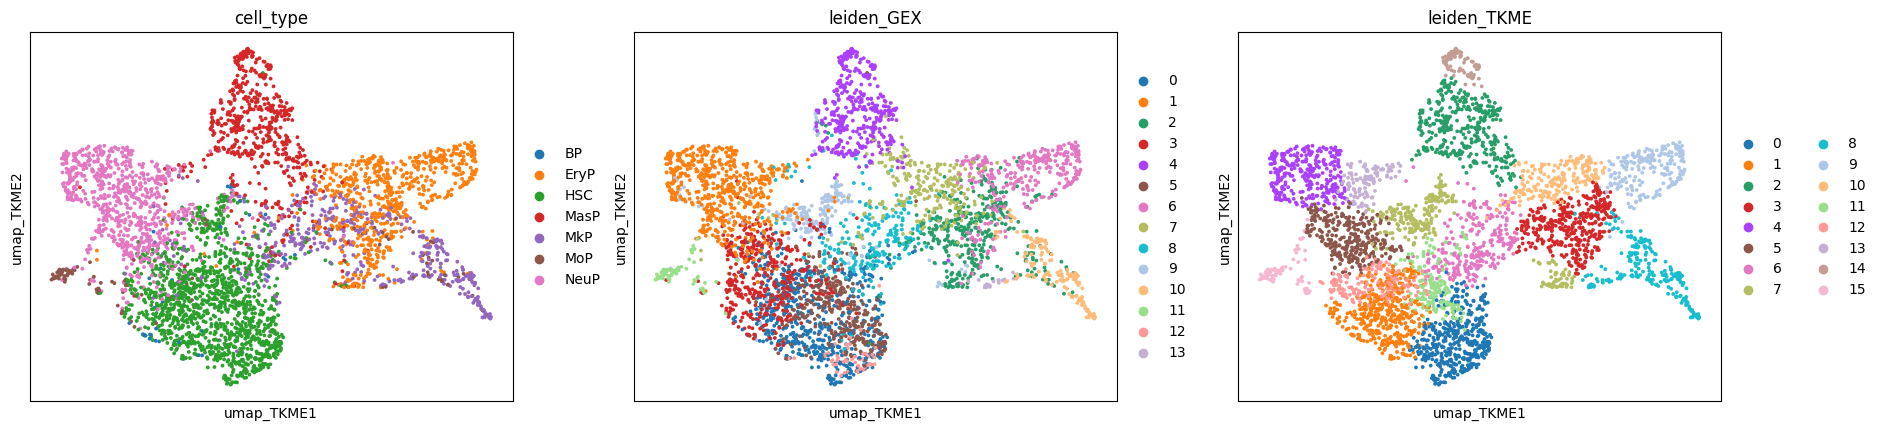

In [14]:
sc.tl.leiden(adata, resolution=1, neighbors_key='neighbors', key_added='leiden_GEX')
sc.tl.leiden(adata, resolution=1, neighbors_key='neighbors_tkme', key_added='leiden_TKME')

sc.pl.embedding(adata, basis='umap_GEX', color=['cell_type', 'leiden_GEX', 'leiden_TKME'])
sc.pl.embedding(adata, basis='umap_TKME', color=['cell_type', 'leiden_GEX', 'leiden_TKME'])

In [15]:
print(adjusted_mutual_info_score(adata.obs['cell_type'], adata.obs['leiden_GEX']))
print(adjusted_mutual_info_score(adata.obs['cell_type'], adata.obs['leiden_TKME']))

0.5130467241173445
0.5077404450623877


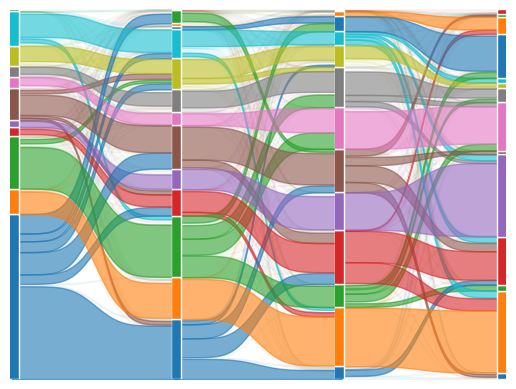

In [16]:
sankey_leiden_gex = sct.plotting.Sankey(ot_model, adata.obs['leiden_GEX'])
_ = sankey_leiden_gex.plot_all_transitions(min_flow_threshold=0.01)

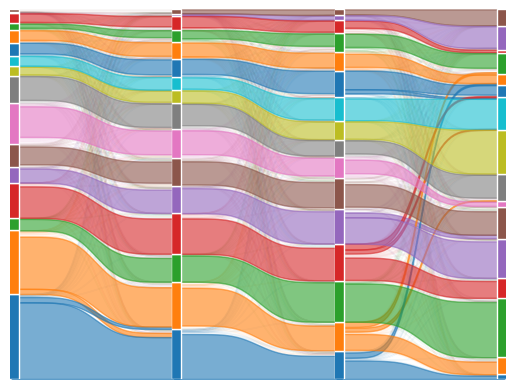

In [17]:
sankey_leiden_tkme = sct.plotting.Sankey(ot_model, adata.obs['leiden_TKME'])
_ = sankey_leiden_tkme.plot_all_transitions(min_flow_threshold=0.01)

## Quantify fate entropy using `scotty-tools`

In [18]:
df = sankey_cell_type.compute_flow_entropy()
1 - df['expected'] / df['prior']

direction  day_0  day_1
forward    2      3        0.491450
           3      4        0.543777
           4      7        0.616302
backward   2      3        0.443357
           3      4        0.570926
           4      7        0.700320
dtype: float64

In [19]:
df = sankey_leiden_tkme.compute_flow_entropy()
1 - df['expected'] / df['prior']

/home/alpaca/miniforge3/envs/scotty-tools-dev/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alpaca/miniforge3/envs/scotty-tools-dev/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alpaca/miniforge3/envs/scotty-tools-dev/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alpaca/miniforge3/envs/scotty-tools-dev/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


direction  day_0  day_1
forward    2      3        0.743750
           3      4        0.763249
           4      7        0.650191
backward   2      3        0.705002
           3      4        0.780218
           4      7        0.807479
dtype: float64

In [20]:
df = sankey_leiden_gex.compute_flow_entropy()
1 - df['expected'] / df['prior']

/home/alpaca/miniforge3/envs/scotty-tools-dev/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alpaca/miniforge3/envs/scotty-tools-dev/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alpaca/miniforge3/envs/scotty-tools-dev/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alpaca/miniforge3/envs/scotty-tools-dev/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alpaca/miniforge3/envs/scotty-tools-dev/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = ge

direction  day_0  day_1
forward    2      3        0.510552
           3      4        0.575409
           4      7        0.627293
backward   2      3        0.561458
           3      4        0.631389
           4      7        0.691684
dtype: float64

/home/alpaca/miniforge3/envs/scotty-tools-dev/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alpaca/projects/scotty-tools/src/scotty/tools/metrics.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freqs = ot_model.meta.join(subsets).groupby(time_var).value_counts(normalize=True)
/home/alpaca/miniforge3/envs/scotty-tools-dev/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alpaca/projects/scotty-tools/src/scotty/tools/metrics.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observ

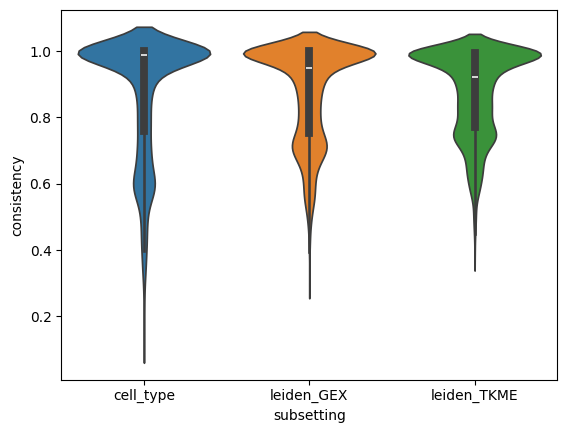

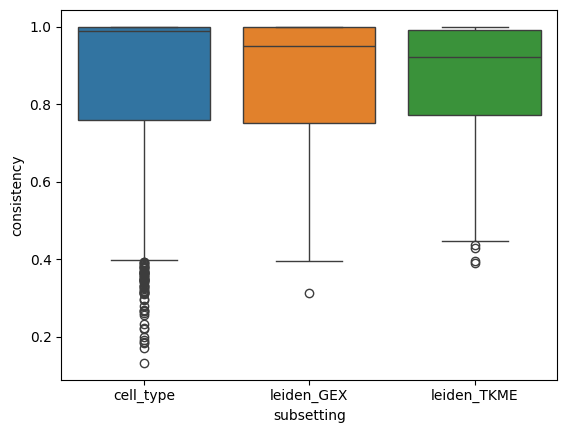

In [21]:
subsettings = ['cell_type', 'leiden_GEX', 'leiden_TKME']
consistency = dict()
for sub in subsettings:
    consistency[sub] = sct.tools.metrics.fate_consistency(ot_model, adata.obs[sub])

consistency = pd.DataFrame(consistency).melt(var_name='subsetting', value_name='consistency')
sns.violinplot(consistency, x='subsetting', y='consistency', hue='subsetting')
plt.show()
sns.boxplot(consistency, x='subsetting', y='consistency', hue='subsetting')
plt.show()